In [1]:
import os 
import pandas as pd
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from log_parser_lib import *
from AB_score_lib import *
import datetime

In [8]:
netconf_file_path='../2401_log_netconf/ncclient/juniper'


In [9]:
file_list=os.listdir(netconf_file_path)
file_list.sort()
file_list

['.gitkeep',
 '2024-01-08T16-59-50.json',
 '2024-01-08T17-05-01.json',
 '2024-01-08T17-10-16.json',
 '2024-01-08T17-15-29.json',
 '2024-01-08T17-20-42.json',
 '2024-01-08T17-25-56.json',
 '2024-01-08T17-31-10.json',
 '2024-01-08T17-36-23.json',
 '2024-01-08T17-41-38.json',
 '2024-01-08T17-46-51.json',
 '2024-01-08T17-52-06.json',
 '2024-01-08T17-57-19.json',
 '2024-01-08T18-02-33.json',
 '2024-01-08T18-07-47.json',
 '2024-01-08T18-13-01.json',
 '2024-01-08T18-18-15.json',
 '2024-01-08T18-23-29.json',
 '2024-01-08T18-28-42.json',
 '2024-01-08T18-33-56.json',
 '2024-01-08T18-39-10.json',
 '2024-01-08T18-44-24.json',
 '2024-01-08T18-49-38.json',
 '2024-01-08T18-54-52.json',
 '2024-01-08T19-00-07.json',
 '2024-01-08T19-05-21.json',
 '2024-01-08T19-10-35.json',
 '2024-01-08T19-15-49.json',
 '2024-01-08T19-21-04.json',
 '2024-01-08T19-26-17.json',
 '2024-01-08T19-31-32.json',
 '2024-01-08T19-36-46.json',
 '2024-01-08T19-42-00.json',
 '2024-01-08T19-47-14.json',
 '2024-01-08T19-52-27.json',
 

In [10]:
def json_date_parsing(file_name):
    date_=datetime.datetime.strptime(file_name, '%Y-%m-%dT%H-%M-%S.json')
    return date_

In [11]:
json_date_parsing(file_list[1])

datetime.datetime(2024, 1, 8, 16, 59, 50)

In [12]:
def json_read_content(file_name):
    with open(file_name) as f:
        json_data=json.load(f)
    del json_data['time'], json_data['down-interfaces'], json_data['up-interfaces'], json_data['interface-information']
    stat=json_data['statistics']
    del json_data['statistics']
    for protocol in stat.keys():
        for key, value in stat[protocol].items():
            if type(value)==int and value!=0:
                json_data[protocol+'-'+key]=value
    #print(json_data.keys())
    json_data['cpu-util']=int(json_data['cpu-util'][:-1])
    json_data['mem-util']=int(json_data['mem-util'][:-1])
    json_data['chassi-temperature']=int(json_data['chassi-temperature'][:-1])
    return json_data

In [13]:
data=pd.DataFrame()
for single_file in file_list:
    if not single_file.endswith('.json'):
        continue
    file_date=json_date_parsing(single_file)
    file_content=json_read_content(netconf_file_path+'/'+single_file)
    data=data.append(pd.Series(file_content, name=file_date))

In [14]:
data

,chassi-temperature,cpu-util,mem-util,arp-arp-replies-sent,arp-arp-requests-received,arp-datagrams-received,icmp-calls-to-icmp-error,ip-incoming-ttpoip-packets-received,ip-outgoing-ttpoip-packets-sent,ip-output-packets-discarded-due-to-no-route,...,tcp-packets-received-after-close,tcp-connections-updated-rtt-on-close,tcp-connections-updated-variance-on-close,tcp-byte-retransmits,tcp-retransmit-timeouts,tcp-retransmitted-bytes,tcp-sack-options-received,tcp-sack-recovery-episodes,tcp-segment-retransmits,tcp-sent-data-packets-retransmitted
2024-01-08 16:59:50,40.0,23.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-08 17:05:01,40.0,22.0,16.0,10.0,10.0,10.0,139.0,3128.0,4310.0,192.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-08 17:10:16,40.0,20.0,16.0,12.0,12.0,12.0,142.0,2455.0,4131.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-08 17:15:29,40.0,20.0,16.0,12.0,12.0,12.0,137.0,2442.0,4453.0,193.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-08 17:20:42,40.0,21.0,16.0,11.0,11.0,11.0,138.0,2829.0,4494.0,196.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-24 20:42:24,40.0,21.0,18.0,13.0,13.0,14.0,136.0,3384.0,5225.0,3.0,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-24 20:47:37,40.0,17.0,18.0,13.0,13.0,13.0,142.0,5303.0,7493.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-24 20:52:52,40.0,21.0,18.0,9.0,9.0,9.0,138.0,3619.0,4816.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-24 20:58:06,40.0,21.0,18.0,11.0,11.0,11.0,135.0,2098.0,2794.0,NaN,...,NaN,1.0,1.0,9936.0,4.0,4344.0,424.0,6.0,20.0,3.0


In [15]:
column_means=data.mean()
column_means[column_means==0].index

Index([], dtype='object')

In [16]:
data.fillna(0,inplace=True)
condition1=data.index > datetime.datetime(2024,1,17,0,0)
condition2=data.index < datetime.datetime(2024,1,16,12,0)
data=data.loc[condition1|condition2]

In [17]:
len(data)

4314

In [18]:
grouped_data=data.groupby(pd.Grouper(freq='6H'))

In [19]:
input_feature_num=data.shape[1]
input_feature_num

62

In [20]:
dataset_size=len(grouped_data)
tmp_=0
for key, group in grouped_data:
    if len(group)==0:
        tmp_+=1
dataset_size-=tmp_
dataset_size

64

In [37]:
# RNN 모델 정의
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, input_size)
        self.fc2 = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc1(out[:, -1, :])  # 마지막 time step의 출력만 사용
        out = self.fc2(out)
        return out

In [40]:
# 사용자 정의 데이터셋 클래스 정의
class CustomPaddedDataset(Dataset):
    def __init__(self, dataframe_groupby, output_data, input_feature_num):
        self.dataframe_groupby = dataframe_groupby
        self.group_names=[]
        for key, group in dataframe_groupby:
            if len(group)!=0:
                self.group_names.append(key)            
        self.max_seq_len=max(len(group[1]) for group in grouped_data)
        self.output_data=output_data

    def __len__(self):
        return len(self.dataframe_groupby)

    def __getitem__(self, idx):
        # 각 그룹의 데이터 가져오기
        group = self.dataframe_groupby.get_group(self.group_names[idx])
        group_tensor = torch.tensor(group.values, dtype=torch.float32)
        pad_amount=[]
        padded_group_tensor=nn.functional.pad(group_tensor, pad=(0,0,0,self.max_seq_len-len(group)))
        #features = group.values  # 입력 특성
        return padded_group_tensor, torch.tensor(self.output_data[idx])

In [304]:
hidden_size = input_feature_num*2 
output_size = 1 
batch_size = 8

train_ratio = 0.7
valid_ratio = 1 - train_ratio
indices = list(range(dataset_size))
split = int(valid_ratio * dataset_size)
np.random.shuffle(indices)
train_indices, valid_indices = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

split_timestamp=datetime.datetime(2024,1,16,12,0)
targets=[1 if k < split_timestamp else 0 for k in grouped_data.groups]

model = SimpleRNN(input_feature_num, hidden_size, output_size)
dataset = CustomPaddedDataset(grouped_data, targets, input_feature_num)
train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_dataloader = DataLoader(dataset,sampler=valid_sampler)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [305]:
num_epochs = 1000
losses=[]
accuraccies=[]
epoches=[]
for epoch in range(num_epochs):
    for batch_inputs, batch_outputs in train_dataloader:
        optimizer.zero_grad()  # 그래디언트 초기화
        outputs = model(batch_inputs)  # 모델 예측
        #print(outputs)
        #print(outputs.squeeze().shape, batch_outputs.shape)
        loss = criterion(outputs.squeeze(), batch_outputs.float())  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
    if epoch%50 ==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        losses.append(loss.item())
        epoches.append(epoch+1)
        right=0 
        false=0
        for batch_inputs, batch_outputs in test_dataloader:
            outputs=model(batch_inputs)
            if (outputs > 0.5 and batch_outputs==1) or (outputs<= 0.5 and batch_outputs==0):
                right+=1
            else:
                false+=1
        accuraccies.append(right/(right+false))
        print(f'Predciction accuracy is {right/(right+false):.2f}')

Epoch [1/1000], Loss: 0.5061
Predciction accuracy is 0.44
Epoch [51/1000], Loss: 0.5783
Predciction accuracy is 0.44
Epoch [101/1000], Loss: 0.3450
Predciction accuracy is 0.44
Epoch [151/1000], Loss: 0.6855
Predciction accuracy is 0.44
Epoch [201/1000], Loss: 1.1006
Predciction accuracy is 0.49
Epoch [251/1000], Loss: 0.2216
Predciction accuracy is 0.49
Epoch [301/1000], Loss: 0.5409
Predciction accuracy is 0.44
Epoch [351/1000], Loss: 0.3086
Predciction accuracy is 0.49
Epoch [401/1000], Loss: 0.3741
Predciction accuracy is 0.44
Epoch [451/1000], Loss: 0.5362
Predciction accuracy is 0.49
Epoch [501/1000], Loss: 0.6657
Predciction accuracy is 0.44
Epoch [551/1000], Loss: 1.0333
Predciction accuracy is 0.49
Epoch [601/1000], Loss: 0.6486
Predciction accuracy is 0.49
Epoch [651/1000], Loss: 0.8912
Predciction accuracy is 0.49
Epoch [701/1000], Loss: 0.5322
Predciction accuracy is 0.44
Epoch [751/1000], Loss: 0.8385
Predciction accuracy is 0.44
Epoch [801/1000], Loss: 0.5307
Predciction 

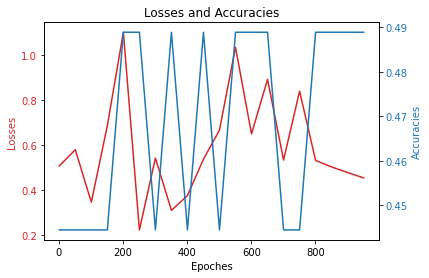

In [306]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epoches')
ax1.set_ylabel('Losses', color=color)
ax1.plot(epoches, losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# 두 번째 축 (accuracies)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracies', color=color)
ax2.plot(epoches, accuraccies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# 그래프 출력
plt.title('Losses and Accuracies')
plt.show()


# Let's calculate IF-IDF now

In [2]:
with open('data.pkl','rb') as f:
    data=pkl.load(f)
(log_dict, synant_dict, log_patterns,event_list),(Q, sigma, delta, initialState, F_) = data
with open('tf_data.pkl', 'rb')as f:
    data=pkl.load(f)
tf_idf, num_all_docs = data
print(f'event num is {len(event_list)}')

event num is 50


In [89]:
log_path='../2401_log_netconf/log'
log_data=pd.DataFrame()
norm_num=0
date_list=os.listdir(log_path)
                     
for date in date_list:
    if os.path.isfile(log_path+'/'+date) or date.startswith('06'):
        continue
    dir_list=os.listdir(log_path+'/'+date)
    single_log_data=[]
    mon=int(date[:2])
    day=int(date[3:])
    for dir_name in dir_list:
        file_list=os.listdir(log_path+'/'+date+'/'+dir_name)
        for file_name in file_list:
            #print(log_path+'/'+date+'/'+dir_name+'/'+file_name)
            log_=read_file(log_path+'/'+date+'/'+dir_name+'/'+file_name)
        if log_:
            single_log_data.extend(log_)
    df=pd.DataFrame(single_log_data)
    df['date']=df['date'].apply(lambda x: x.replace(year=2024, month=mon, day=day))
    df.set_index('date', inplace=True)
    log_data=pd.concat([log_data, df])
log_data=log_data.sort_index()
#grouped_data=df.groupby(pd.Grouper(freq='6H'))
'''
        norm_num+=1
print(f'{norm_num} of normal data readed')
assert(norm_num==len(log_data))
abnorm_log_data=[]
abnorm_num=0
abnorm_date_list=os.listdir(abnormal_log_path)
for date in abnorm_date_list:
    if os.path.isfile(abnormal_log_path+'/'+date):
        continue
    log_=read_file(abnormal_log_path+'/'+date+'/all.log')
    if log_:
        abnorm_log_data.append(log_)
        abnorm_num+=1
print(f'{abnorm_num} of abnormal data readed')'''

"\n        norm_num+=1\nprint(f'{norm_num} of normal data readed')\nassert(norm_num==len(log_data))\nabnorm_log_data=[]\nabnorm_num=0\nabnorm_date_list=os.listdir(abnormal_log_path)\nfor date in abnorm_date_list:\n    if os.path.isfile(abnormal_log_path+'/'+date):\n        continue\n    log_=read_file(abnormal_log_path+'/'+date+'/all.log')\n    if log_:\n        abnorm_log_data.append(log_)\n        abnorm_num+=1\nprint(f'{abnorm_num} of abnormal data readed')"

In [91]:
tf_idf_results=calculate_abnormal_score_for_df(log_data,log_dict, log_patterns, event_list, tf_idf, num_all_docs)

64


In [92]:
tf_idf_results

,tf_idf,occurence_probability,repeat_rate
2024-01-08 04:46:23,4.45137,1,0.693147
2024-01-08 05:12:17,8.12705,1,0.693147
2024-01-08 05:15:49,4.13738,1,0.693147
2024-01-08 05:19:26,2.76719,1,0.693147
2024-01-08 05:23:07,5.14025,1,0.693147
...,...,...,...
2024-01-31 14:28:24,5.14025,1,0.693147
2024-01-31 14:37:49,5.14025,1,0.693147
2024-01-31 14:37:52,5.14025,1,0.693147
2024-01-31 14:37:53,5.14025,1,0.693147


In [72]:
def calculate_average_values(row_B, df_A, column_name, window_minutes):
    window_start = row_B.name - pd.Timedelta(minutes=window_minutes)
    window_end = row_B.name + pd.Timedelta(minutes=window_minutes)
    filtered_values = df_A[column_name].loc[(df_A.index >= window_start) & (df_A.index <= window_end)]
    if not filtered_values.empty:
        return filtered_values.mean()
    else:
        return None

In [77]:
window_minutes = 10
tf_idf_results_cp=tf_idf_results
for column_name, column in data.items():
    tf_idf_results_cp['average_'+column_name]=tf_idf_results_cp.apply(lambda row: calculate_average_values(row, data, column_name, window_minutes), axis=1)

In [80]:
merged_df=tf_idf_results_cp

In [67]:
merged_df=pd.merge_asof(data, tf_idf_results, left_index=True, right_index=True, tolerance=pd.Timedelta('5 minute'))

In [81]:
#merged_df['occurence_probability'].fillna(1,inplace=True)
#merged_df.fillna(0,inplace=True)
merged_df=merged_df.fillna(method='ffill')
merged_df=merged_df.dropna()
merged_df.fillna(0,inplace=True)
condition1=merged_df.index > datetime.datetime(2024,1,17,0,0)
condition2=merged_df.index < datetime.datetime(2024,1,16,12,0)
merged_df=merged_df.loc[condition1|condition2]

In [88]:
tf_idf_results_cp

,tf_idf,occurence_probability,repeat_rate,average_chassi-temperature,average_cpu-util,average_mem-util,average_arp-arp-replies-sent,average_arp-arp-requests-received,average_arp-datagrams-received,average_icmp-calls-to-icmp-error,...,average_tcp-packets-received-after-close,average_tcp-connections-updated-rtt-on-close,average_tcp-connections-updated-variance-on-close,average_tcp-byte-retransmits,average_tcp-retransmit-timeouts,average_tcp-retransmitted-bytes,average_tcp-sack-options-received,average_tcp-sack-recovery-episodes,average_tcp-segment-retransmits,average_tcp-sent-data-packets-retransmitted
2024-01-08 04:46:23,4.45137,1,0.693147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-08 05:12:17,8.12705,1,0.693147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-08 05:15:49,4.13738,1,0.693147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-08 05:19:26,2.76719,1,0.693147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-08 05:23:07,5.14025,1,0.693147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 14:28:24,5.14025,1,0.693147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-31 14:37:49,5.14025,1.2e-06,0.693147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-31 14:37:52,5.14025,1.2e-06,0.693147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-31 14:37:53,5.14025,1.2e-06,0.693147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
tf_idf_results_cp.mean()

tf_idf                                          4.333234
occurence_probability                           0.984718
repeat_rate                                     0.693147
average_chassi-temperature                     41.072607
average_cpu-util                               20.359530
                                                 ...    
average_tcp-retransmitted-bytes                 1.344059
average_tcp-sack-options-received               0.131188
average_tcp-sack-recovery-episodes              0.001856
average_tcp-segment-retransmits                 0.006188
average_tcp-sent-data-packets-retransmitted     0.000928
Length: 65, dtype: float64

In [96]:
tf_idf_results.fillna(0,inplace=True)
condition1=tf_idf_results.index > datetime.datetime(2024,1,17,0,0)
condition2=tf_idf_results.index < datetime.datetime(2024,1,16,12,0)
tf_idf_results=tf_idf_results.loc[condition1|condition2]
grouped_data=tf_idf_results.groupby(pd.Grouper(freq='6H'))
input_feature_num=tf_idf_results.shape[1]
input_feature_num

3

In [97]:
dataset_size=len(grouped_data)
tmp_=0
for key, group in grouped_data:
    if len(group)==0:
        tmp_+=1
dataset_size-=tmp_
dataset_size

72

In [98]:
hidden_size = input_feature_num*2 
output_size = 1 
batch_size = 8

train_ratio = 0.7
valid_ratio = 1 - train_ratio
indices = list(range(dataset_size))
split = int(valid_ratio * dataset_size)
np.random.shuffle(indices)
train_indices, valid_indices = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

split_timestamp=datetime.datetime(2024,1,16,12,0)
targets=[1 if k < split_timestamp else 0 for k in grouped_data.groups]

model = SimpleRNN(input_feature_num, hidden_size, output_size)
dataset = CustomPaddedDataset(grouped_data, targets, input_feature_num)
train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_dataloader = DataLoader(dataset,sampler=valid_sampler)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
losses=[]
accuraccies=[]
epoches=[]
for epoch in range(num_epochs):
    for batch_inputs, batch_outputs in train_dataloader:
        optimizer.zero_grad()  # 그래디언트 초기화
        outputs = model(batch_inputs)  # 모델 예측
        #print(outputs)
        #print(outputs.squeeze().shape, batch_outputs.shape)
        loss = criterion(outputs.squeeze(), batch_outputs.float())  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
    if epoch%50 ==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        losses.append(loss.item())
        epoches.append(epoch+1)
        right=0 
        false=0
        for batch_inputs, batch_outputs in test_dataloader:
            outputs=model(batch_inputs)
            if (outputs > 0.5 and batch_outputs==1) or (outputs<= 0.5 and batch_outputs==0):
                right+=1
            else:
                false+=1
        accuraccies.append(right/(right+false))
        print(f'Predciction accuracy is {right/(right+false):.2f}')

Epoch [1/1000], Loss: 0.7063
Predciction accuracy is 0.53
Epoch [51/1000], Loss: 0.6647
Predciction accuracy is 0.53
Epoch [101/1000], Loss: 0.6715
Predciction accuracy is 0.53
Epoch [151/1000], Loss: 0.6757
Predciction accuracy is 0.53
Epoch [201/1000], Loss: 0.7601
Predciction accuracy is 0.53
Epoch [251/1000], Loss: 0.7723
Predciction accuracy is 0.53
Epoch [301/1000], Loss: 0.7915
Predciction accuracy is 0.53
Epoch [351/1000], Loss: 0.6004
Predciction accuracy is 0.53
Epoch [401/1000], Loss: 0.6107
Predciction accuracy is 0.53
Epoch [451/1000], Loss: 0.6863
Predciction accuracy is 0.53
Epoch [501/1000], Loss: 0.6204
Predciction accuracy is 0.53
Epoch [551/1000], Loss: 0.5684
Predciction accuracy is 0.53
Epoch [601/1000], Loss: 0.6607
Predciction accuracy is 0.53
Epoch [651/1000], Loss: 0.6555
Predciction accuracy is 0.53
Epoch [701/1000], Loss: 0.7467
Predciction accuracy is 0.53
Epoch [751/1000], Loss: 0.7430
Predciction accuracy is 0.53
Epoch [801/1000], Loss: 0.6176
Predciction 

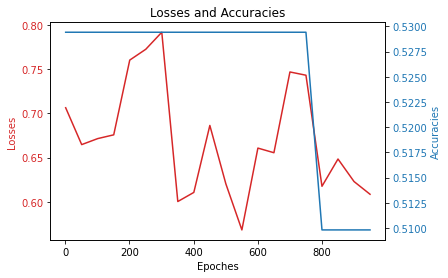

In [99]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epoches')
ax1.set_ylabel('Losses', color=color)
ax1.plot(epoches, losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# 두 번째 축 (accuracies)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracies', color=color)
ax2.plot(epoches, accuraccies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# 그래프 출력
plt.title('Losses and Accuracies')
plt.show()
